In [24]:
import random
import json
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Bidirectional, LSTM, Input, Attention, Flatten, Concatenate  
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import gensim.models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score
import pandas as pd

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
w2v_model = gensim.models.Word2Vec.load("data/output/gram.model")

In [27]:

intents = json.loads(open('data/input/intents.json').read())

In [28]:
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

In [29]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [30]:
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))

classes = sorted(set(classes))

In [31]:
pickle.dump(words, open('data/output/Attention/words.pkl', 'wb'))
pickle.dump(classes, open('data/output/Attention/classes.pkl', 'wb'))


In [32]:
training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)

In [33]:
# Separate train_x and train_y
train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [34]:
input_layer = Input(shape=(len(train_x[0]),))
embedding_layer = Embedding(input_dim=len(words), output_dim=100)(input_layer)
lstm_layer = Bidirectional(LSTM(130, return_sequences=True))(embedding_layer)
attention1 = Attention()([lstm_layer, lstm_layer])
attention1 = Flatten()(attention1)
lstm_layer2 = Bidirectional(LSTM(130, return_sequences=True))(lstm_layer)
attention2 = Attention()([lstm_layer2, lstm_layer2])
attention2 = Flatten()(attention2)
concatenated_attention = Concatenate()([attention1, attention2])
output_layer = Dense(len(train_y[0]), activation='softmax')(concatenated_attention)

model = Model(inputs=[input_layer], outputs=[output_layer])

In [35]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [36]:
early_stopping = EarlyStopping(monitor='accuracy', patience=60, verbose=1)
history = model.fit(train_x, train_y, epochs=1500, batch_size=16, verbose=1, callbacks=[early_stopping])


Epoch 1/1500


/home/misti-rani/Desktop/Projects/Mayabati---Your-Personal-AI-Chef/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 143))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - accuracy: 0.1859 - loss: 2.3645
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - accuracy: 0.1974 - loss: 2.2198
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.1656 - loss: 2.2220
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.1866 - loss: 2.1301
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.2493 - loss: 2.1373
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.1629 - loss: 2.2017
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - accuracy: 0.2268 - loss: 2.1558
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step - accuracy: 0.1945 - loss: 2.2025
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.2075 - loss: 2.1504
Epoch 10/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.1627 - loss: 2.1335
Epoch 11/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.2099 - loss: 2.1460
Epoch 12/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 

In [44]:
# Model evaluation
predictions = model.predict(train_x)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(train_y, axis=1)

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

info_precision = precision  
info_recall = recall  
info_f1 = f1  

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


In [45]:
# Define metrics for Intent Classification and Information Extraction
metrics_data = {
    "Metric": ["Precision", "Recall", "F1-Score"],
    "Intent Classification": [precision, recall, f1],
    "Information Extraction": [info_precision, info_recall, info_f1]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
print(metrics_df.to_string(index=False))

   Metric  Intent Classification  Information Extraction
Precision               0.983570                0.983570
   Recall               0.980583                0.980583
 F1-Score               0.980785                0.980785


<Figure size 800x500 with 0 Axes>

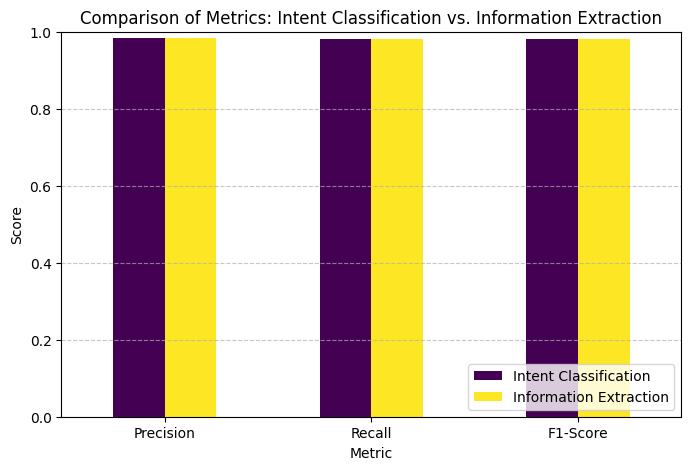

In [50]:
# Visualization - Bar Chart
plt.figure(figsize=(8, 5))
metrics_df.set_index("Metric").plot(kind="bar", figsize=(8, 5), colormap="viridis")
plt.title("Comparison of Metrics: Intent Classification vs. Information Extraction")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [46]:
# Save the model
model.save('data/output/Attention/Rasika.keras')

In [47]:
# Print "Done"
print("Done")

Done


In [60]:
# Plot training history
plt.figure(figsize=(19.20, 10.80))

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

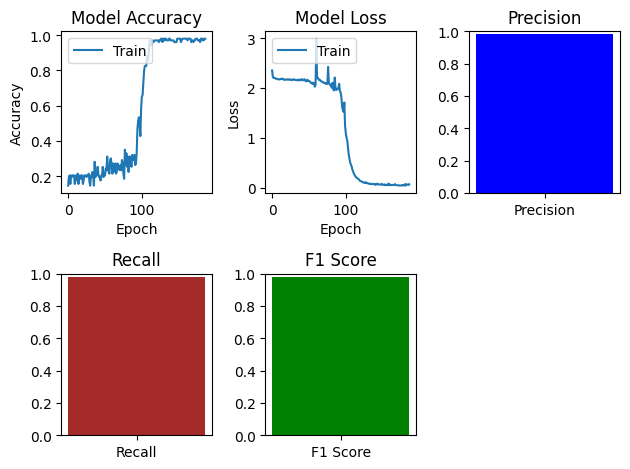

In [64]:
# Plot training accuracy
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, position 1
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(2, 3, 2)  # 2 rows, 3 columns, position 2
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

# Plot Precision
plt.subplot(2, 3, 3)  # 2 rows, 3 columns, position 3
plt.bar(['Precision'], [precision], color='blue')
plt.ylim(0, 1)
plt.title('Precision')

# Plot Recall
plt.subplot(2, 3, 4)  # 2 rows, 3 columns, position 4
plt.bar(['Recall'], [recall], color='brown')
plt.ylim(0, 1)
plt.title('Recall')

# Plot F1 Score
plt.subplot(2, 3, 5)  # 2 rows, 3 columns, position 5
plt.bar(['F1 Score'], [f1], color='green')
plt.ylim(0, 1)
plt.title('F1 Score')

# Adjust layout and show plots
plt.tight_layout()
plt.show()